#**WaterDRoP**

This notebook uses the WaterDRoP model to estimate the rate of hydrolysis from a chemical SMILES string.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amelielemay/WaterDrop/blob/main/WaterDrop.ipynb)

Enter a single SMILES string below. Scroll to 'Batch Mode' to enter a file of multiple SMILES strings.

## Enter SMILES string

In [ ]:
smiles = 'CC(C)(/C=N/OC(=O)NC)SC'

### Run the following cells

In [ ]:
# Install packages
result = !pip install chemprop --quiet
print("chemprop installed.")

chemprop installed.


In [ ]:
# Imports
import chemprop
from chemprop import featurizers, data, models
import pandas as pd
import numpy as np
import os
import random
import torch
import lightning
import logging
from lightning import pytorch as pl
from google.colab import files
from rdkit import Chem
from rdkit.Chem import Draw, DataStructs, Descriptors
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

In [ ]:
# Turn off PyTorch messages
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

In [ ]:
# Download training data from Github
!wget -q https://raw.githubusercontent.com/amelielemay/WaterDRoP/refs/heads/main/data/training_data.csv
!wget -q https://raw.githubusercontent.com/amelielemay/WaterDRoP/refs/heads/main/data/sample_input_data.csv

## Download WaterDRoP

The following cells download the trained WaterDRoP models. It should take several minutes.

In [ ]:
%%writefile openssl.cnf
openssl_conf = openssl_init

[openssl_init]
ssl_conf = ssl_sect

[ssl_sect]
system_default = system_default_sect

[system_default_sect]
MinProtocol = TLSv1.2
CipherString = DEFAULT@SECLEVEL=1

Writing openssl.cnf


In [ ]:
total_files = 8
file_count = 1

for stage in [1, 2]:
    for n in [1, 2, 3, 4]:
        filename = f"wd_stg{stage}_n{n}.pt"
        url = f"https://platalab.mit.edu/www/models/{filename}"
        print(f"\nDownloading {filename} (Model {file_count} of {total_files})...")
        !OPENSSL_CONF=openssl.cnf wget -q --show-progress -O {filename} {url}
        print(f"Model {file_count} of {total_files} downloaded")
        file_count += 1


wd_stg1_n1.pt       100%[===================>]  35.60M   851KB/s    in 43s     
Model 1 of 8 downloaded

wd_stg1_n2.pt       100%[===================>]  35.60M   880KB/s    in 42s     
Model 2 of 8 downloaded

wd_stg1_n3.pt       100%[===================>]  35.60M   855KB/s    in 43s     
Model 3 of 8 downloaded

wd_stg1_n4.pt       100%[===================>]  35.60M   862KB/s    in 43s     
Model 4 of 8 downloaded

wd_stg2_n1.pt       100%[===================>]  35.60M   850KB/s    in 43s     
Model 5 of 8 downloaded

wd_stg2_n2.pt       100%[===================>]  35.60M   880KB/s    in 42s     
Model 6 of 8 downloaded

wd_stg2_n3.pt       100%[===================>]  35.60M   854KB/s    in 43s     
Model 7 of 8 downloaded

wd_stg2_n4.pt       100%[===================>]  35.60M   845KB/s    in 44s     
Model 8 of 8 downloaded


In [ ]:
# Load downloaded WaterDRoP models
filenames_stg1 = ['wd_stg1_n1.pt', 'wd_stg1_n2.pt', 'wd_stg1_n3.pt', 'wd_stg1_n4.pt']
filenames_stg2 = ['wd_stg2_n1.pt', 'wd_stg2_n2.pt', 'wd_stg2_n3.pt', 'wd_stg2_n4.pt']

stg1_models = [models.MPNN.load_from_file(f) for f in filenames_stg1]
stg2_models = [models.MPNN.load_from_file(f) for f in filenames_stg2]

## Generate hydrolysis rate prediction

In [ ]:
# Featurize input
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
y = np.random.rand(1)
dset = data.MoleculeDataset([data.MoleculeDatapoint.from_smi(smiles, y)], featurizer)
test_loader = data.build_dataloader(dset, batch_size = 1)

In [ ]:
%%capture
# Stage 1 prediction (stable or unstable classification)
predictions = []
for model in stg1_models:
    with torch.inference_mode():
        trainer = pl.Trainer()
        preds = torch.concat(trainer.predict(model, test_loader)).detach().cpu().numpy()
        predictions.append(preds)

predictions = np.array(predictions)
stg1_pred = (predictions.mean(axis=0))[0][0] # average prediction
range_lo_stg1 = (predictions.max(axis=0))[0][0] # lowest model prediction
range_hi_stg1 = (predictions.min(axis=0))[0][0] # highest model prediction

# Stage 2 prediction (half-life of unstable compounds)
predictions = []
for model in stg2_models:
    with torch.inference_mode():
        trainer = pl.Trainer()
        preds = torch.concat(trainer.predict(model, test_loader)).detach().cpu().numpy()
        predictions.append(preds)

predictions = np.array(predictions)
stg2_pred = (predictions.mean(axis=0))[0][0] # average prediction
range_lo_stg2 = (predictions.max(axis=0))[0][0] # lowest model prediction
range_hi_stg2 = (predictions.min(axis=0))[0][0] # highest model prediction

# Final prediction and uncertainty
threshold = np.log(np.log(2)/365)
final_pred = half_life_lo = half_life_hi = unit1 = unit2 = None

if stg1_pred < threshold or stg2_pred < threshold:
    half_life = '> 1 year'
    range_lo = range_lo_stg1
    range_hi = range_hi_stg1
else:
    half_life = f'{float(f"{(np.log(2)/np.exp(stg2_pred)):.2g}"):g}'
    range_lo = range_lo_stg2
    range_hi = range_hi_stg2

if range_lo < threshold:
    half_life_lo = '> 1 year'
else:
    half_life_lo = f'{float(f"{(np.log(2)/np.exp(range_lo)):.2g}"):g}'

if range_hi < threshold:
    half_life_hi = '> 1 year'
else:
    half_life_hi = f'{float(f"{(np.log(2)/np.exp(range_hi)):.2g}"):g}'

unit1 = '' if half_life == '> 1 year' else ('day' if float(half_life) <= 1 else 'days')
unit2 = '' if half_life_lo == '> 1 year' else ('day' if float(half_life_lo) <= 1 else 'days')
unit3 = '' if half_life_hi == '> 1 year' else ('day' if float(half_life_hi) <= 1 else 'days')

## Print estimated hydrolysis half-life

The half-life reflects the average prediction of four trained WaterDRoP models, and the range represents the lowest and highest values of the four predictions.

In [ ]:
print('Input SMILES:', smiles)
print('Estimated hydrolysis half-life:', half_life, unit1)
print('Range:', half_life_lo, unit2, 'to', half_life_hi, unit3)

Input SMILES: CC(C)(/C=N/OC(=O)NC)SC
Estimated hydrolysis half-life: 0.83 day
Range: 0.48 day to 1.3 days


## Similarity search of training data

The following cells display the top matches of a Tanimoto similarity search of the input SMILES string against the data used to train WaterDRoP.

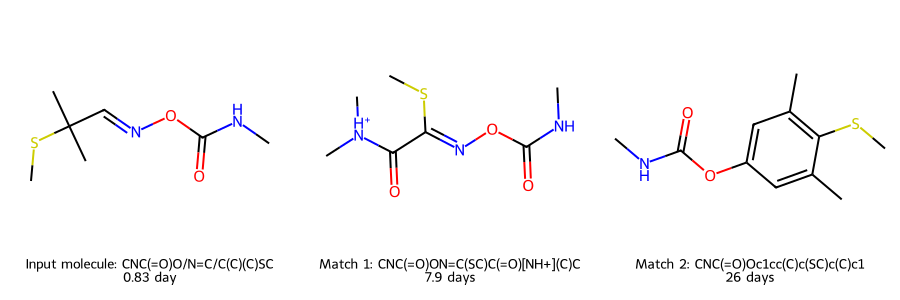

In [ ]:
# Generate fingerprints
training_data = pd.read_csv('training_data.csv')
smis = training_data['SMILES']
half_lives = training_data['half_life_formatted']

input_mol = Chem.MolFromSmiles(smiles)
training_mols = [Chem.MolFromSmiles(smi) for smi in smis]
fp_generator = GetMorganGenerator(radius=3, fpSize=1024)
input_fp = fp_generator.GetFingerprint(input_mol)
train_fps = [fp_generator.GetFingerprint(mol) for mol in training_mols]

# Tanimoto similarity search
similarities = [(DataStructs.TanimotoSimilarity(train_fp, input_fp), smi, hl) for train_fp, smi, hl in zip(train_fps, smis, half_lives)]

# Top matches in training data
top_matches = sorted(similarities, key=lambda x: x[0], reverse=True)[:2]

mols = [Chem.MolFromSmiles(smiles),Chem.MolFromSmiles(top_matches[0][1]),Chem.MolFromSmiles(top_matches[1][1])]

legends = [f'Input molecule: {Chem.MolToSmiles(input_mol)}\n{half_life} {unit1}',
           f'Match 1: {top_matches[0][1]}\n{top_matches[0][2]}',
           f'Match 2: {top_matches[1][1]}\n{top_matches[1][2]}']

drawer = rdMolDraw2D.MolDraw2DSVG(900, 300, 300, 300)
drawer.DrawMolecules(mols, legends=legends)
drawer.FinishDrawing()

svg = drawer.GetDrawingText()
SVG(svg)

To see the experimental sources of the top matches, search for the SMILES string in the [training dataset](https://github.com/amelielemay/WaterDRoP/blob/main/dataset.xlsx).

# Batch Mode

A CSV file of multiple SMILES strings can be uploaded here. The expected format is a column titled "SMILES" with one SMILES string per row. See this [sample file](https://github.com/amelielemay/WaterDRoP/blob/main/data/sample_input_data.csv).

In [ ]:
uploaded = files.upload()

In [ ]:
input_path = 'sample_input_data.csv'

### Run the following cells

In [ ]:
df_input = pd.read_csv(input_path)
input_smis = df_input['SMILES']

featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
y = np.random.rand(1)
dset = data.MoleculeDataset([data.MoleculeDatapoint.from_smi(smiles, y)])
test_loader = data.build_dataloader(dset, batch_size = 1)

smiles_column = 'SMILES'
target_columns = ['target']
smis = df_input.loc[:, smiles_column].values
ys = np.random.rand(len(smis))
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]
test_dset = data.MoleculeDataset(all_data, featurizer)
test_loader = data.build_dataloader(test_dset, shuffle = False, batch_size = len(smis))

In [ ]:
%%capture
# Stage 1 prediction (stable or unstable classification)
predictions = []
for model in stg1_models:
    with torch.inference_mode():
        trainer = pl.Trainer()
        preds = torch.concat(trainer.predict(model, test_loader)).detach().cpu().numpy()
        predictions.append(preds)

predictions = np.array(predictions)
stg1_preds = (predictions.mean(axis=0)) # average predictions
ranges_lo_stg1 = (predictions.max(axis=0)) # lowest model predictions
ranges_hi_stg1 = (predictions.min(axis=0)) # highest model predictions

# Stage 2 prediction (half-life of unstable compounds)
predictions = []
for model in stg2_models:
    with torch.inference_mode():
        trainer = pl.Trainer()
        preds = torch.concat(trainer.predict(model, test_loader)).detach().cpu().numpy()
        predictions.append(preds)

predictions = np.array(predictions)
stg2_preds = (predictions.mean(axis=0)) # average predictions
ranges_lo_stg2 = (predictions.max(axis=0)) # lowest model predictions
ranges_hi_stg2 = (predictions.min(axis=0)) # highest model predictions

# Final prediction and uncertainty
final_preds = []
ranges_lo_str = []
ranges_hi_str = []
threshold = np.log(np.log(2)/365)

for i in range(len(input_smis)):
    if stg1_preds[i] < threshold or stg2_preds[i] < threshold:
        final_preds.append('> 1 year')
        ranges_lo = ranges_lo_stg1[i]
        ranges_hi = ranges_hi_stg1[i]
    else:
        final_preds.append(f'{float(f"{(np.log(2)/np.exp(stg2_preds[i][0])):.2g}"):g}')
        ranges_lo = ranges_lo_stg2[i]
        ranges_hi = ranges_hi_stg2[i]

    if ranges_lo < threshold:
        ranges_lo_str.append('> 1 year')
    else:
        ranges_lo_str.append(f'{float(f"{(np.log(2)/np.exp(ranges_lo[0])):.2g}"):g}')

    if ranges_hi < threshold:
        ranges_hi_str.append('> 1 year')
    else:
        ranges_hi_str.append(f'{float(f"{(np.log(2)/np.exp(ranges_hi[0])):.2g}"):g}')

In [ ]:
output = pd.DataFrame({'SMILES': smis, 'Half-life (days)': final_preds, 'Range, low': ranges_lo_str, 'Range, high': ranges_hi_str})

## Half-life predictions

In [ ]:
output

,SMILES,Half-life (days),"Range, low","Range, high"
0,CC=O,57,57,57
1,CN(C)CCN(CC1=CC=CS1)C2=CC=CC=N2,56,56,56
2,CCSC(=O)N1CCCCCC1,1.7,1.7,1.7
3,CCOC1=CC=C(C=C1)NC(=O)C,> 1 year,> 1 year,> 1 year
4,CC(=S)N,> 1 year,> 1 year,> 1 year


# Save Trained Models

For frequent use of WaterDRoP, the trained models can be downloaded and saved to a local machine. The notebook can then be run as a Jupyter notebook on a local machine, which will avoid having to download the files from the web each time.

### Download models to local machine

In [ ]:
!zip models.zip wd_stg*_n*.pt
files.download("models.zip")

  adding: wd_stg1_n1.pt (deflated 7%)
  adding: wd_stg1_n2.pt (deflated 7%)
  adding: wd_stg1_n3.pt (deflated 7%)
  adding: wd_stg1_n4.pt (deflated 7%)
  adding: wd_stg2_n1.pt (deflated 7%)
  adding: wd_stg2_n2.pt (deflated 7%)
  adding: wd_stg2_n3.pt (deflated 7%)
  adding: wd_stg2_n4.pt (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>